In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapz
from posterior_inference_point import PointSourcePosterior
from posterior_inference_diffuse import DiffusePosterior
import os
from scipy.integrate import cumtrapz

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

* Remove $N=10$
* One panel showing prior dependence for $N_{\mathrm{min}}$

In [49]:
### Setup
n_pbhs = np.array([[1,  1,     10],
                   [80, 24000, 80]]).T
m_pbhs = np.array([[0.5, 10, 100],
                   [0.5, 10, 100]]).T

# LIGO's prior
merger_rate_prior = "J"

# BSM 95% contours
gambit_dir = "data/gambit/"
gambit_models = ["CMSSM", "MSSM7", "NUHM1", "NUHM2", "SingletDM"]
gambit_grid_rows, gambit_grid_cols = 101, 103

# Colors
pbh_colors = {0.5: colors[0], 10: colors[1], 100: colors[2]}

In [22]:
def plot_gambit_contour_envelope(ax, color=None, padding=10, level=6):
    # TODO: Christoph said 3, not 6...
    # Construct parameter meshgrid
    m_dm_g = np.logspace(1, 4, gambit_grid_cols)[padding:]
    sv_g = np.logspace(-35, -23, gambit_grid_rows)[padding:]
    m_dm_g_mg, sv_g_mg = np.meshgrid(m_dm_g, sv_g)

    # Construct envelope of contours
    envelope = np.inf * np.ones([gambit_grid_rows - padding, gambit_grid_cols - padding])
    for model in gambit_models:
        gambit_contour = np.load(
            "{}contours_{}.npy".format(gambit_dir, model)).T[padding:, padding:]
        envelope = np.min([envelope, gambit_contour], axis=0)
    
    ax.contourf(m_dm_g_mg, sv_g_mg, envelope, levels=[0, level], alpha=0.3,
                colors=[color])

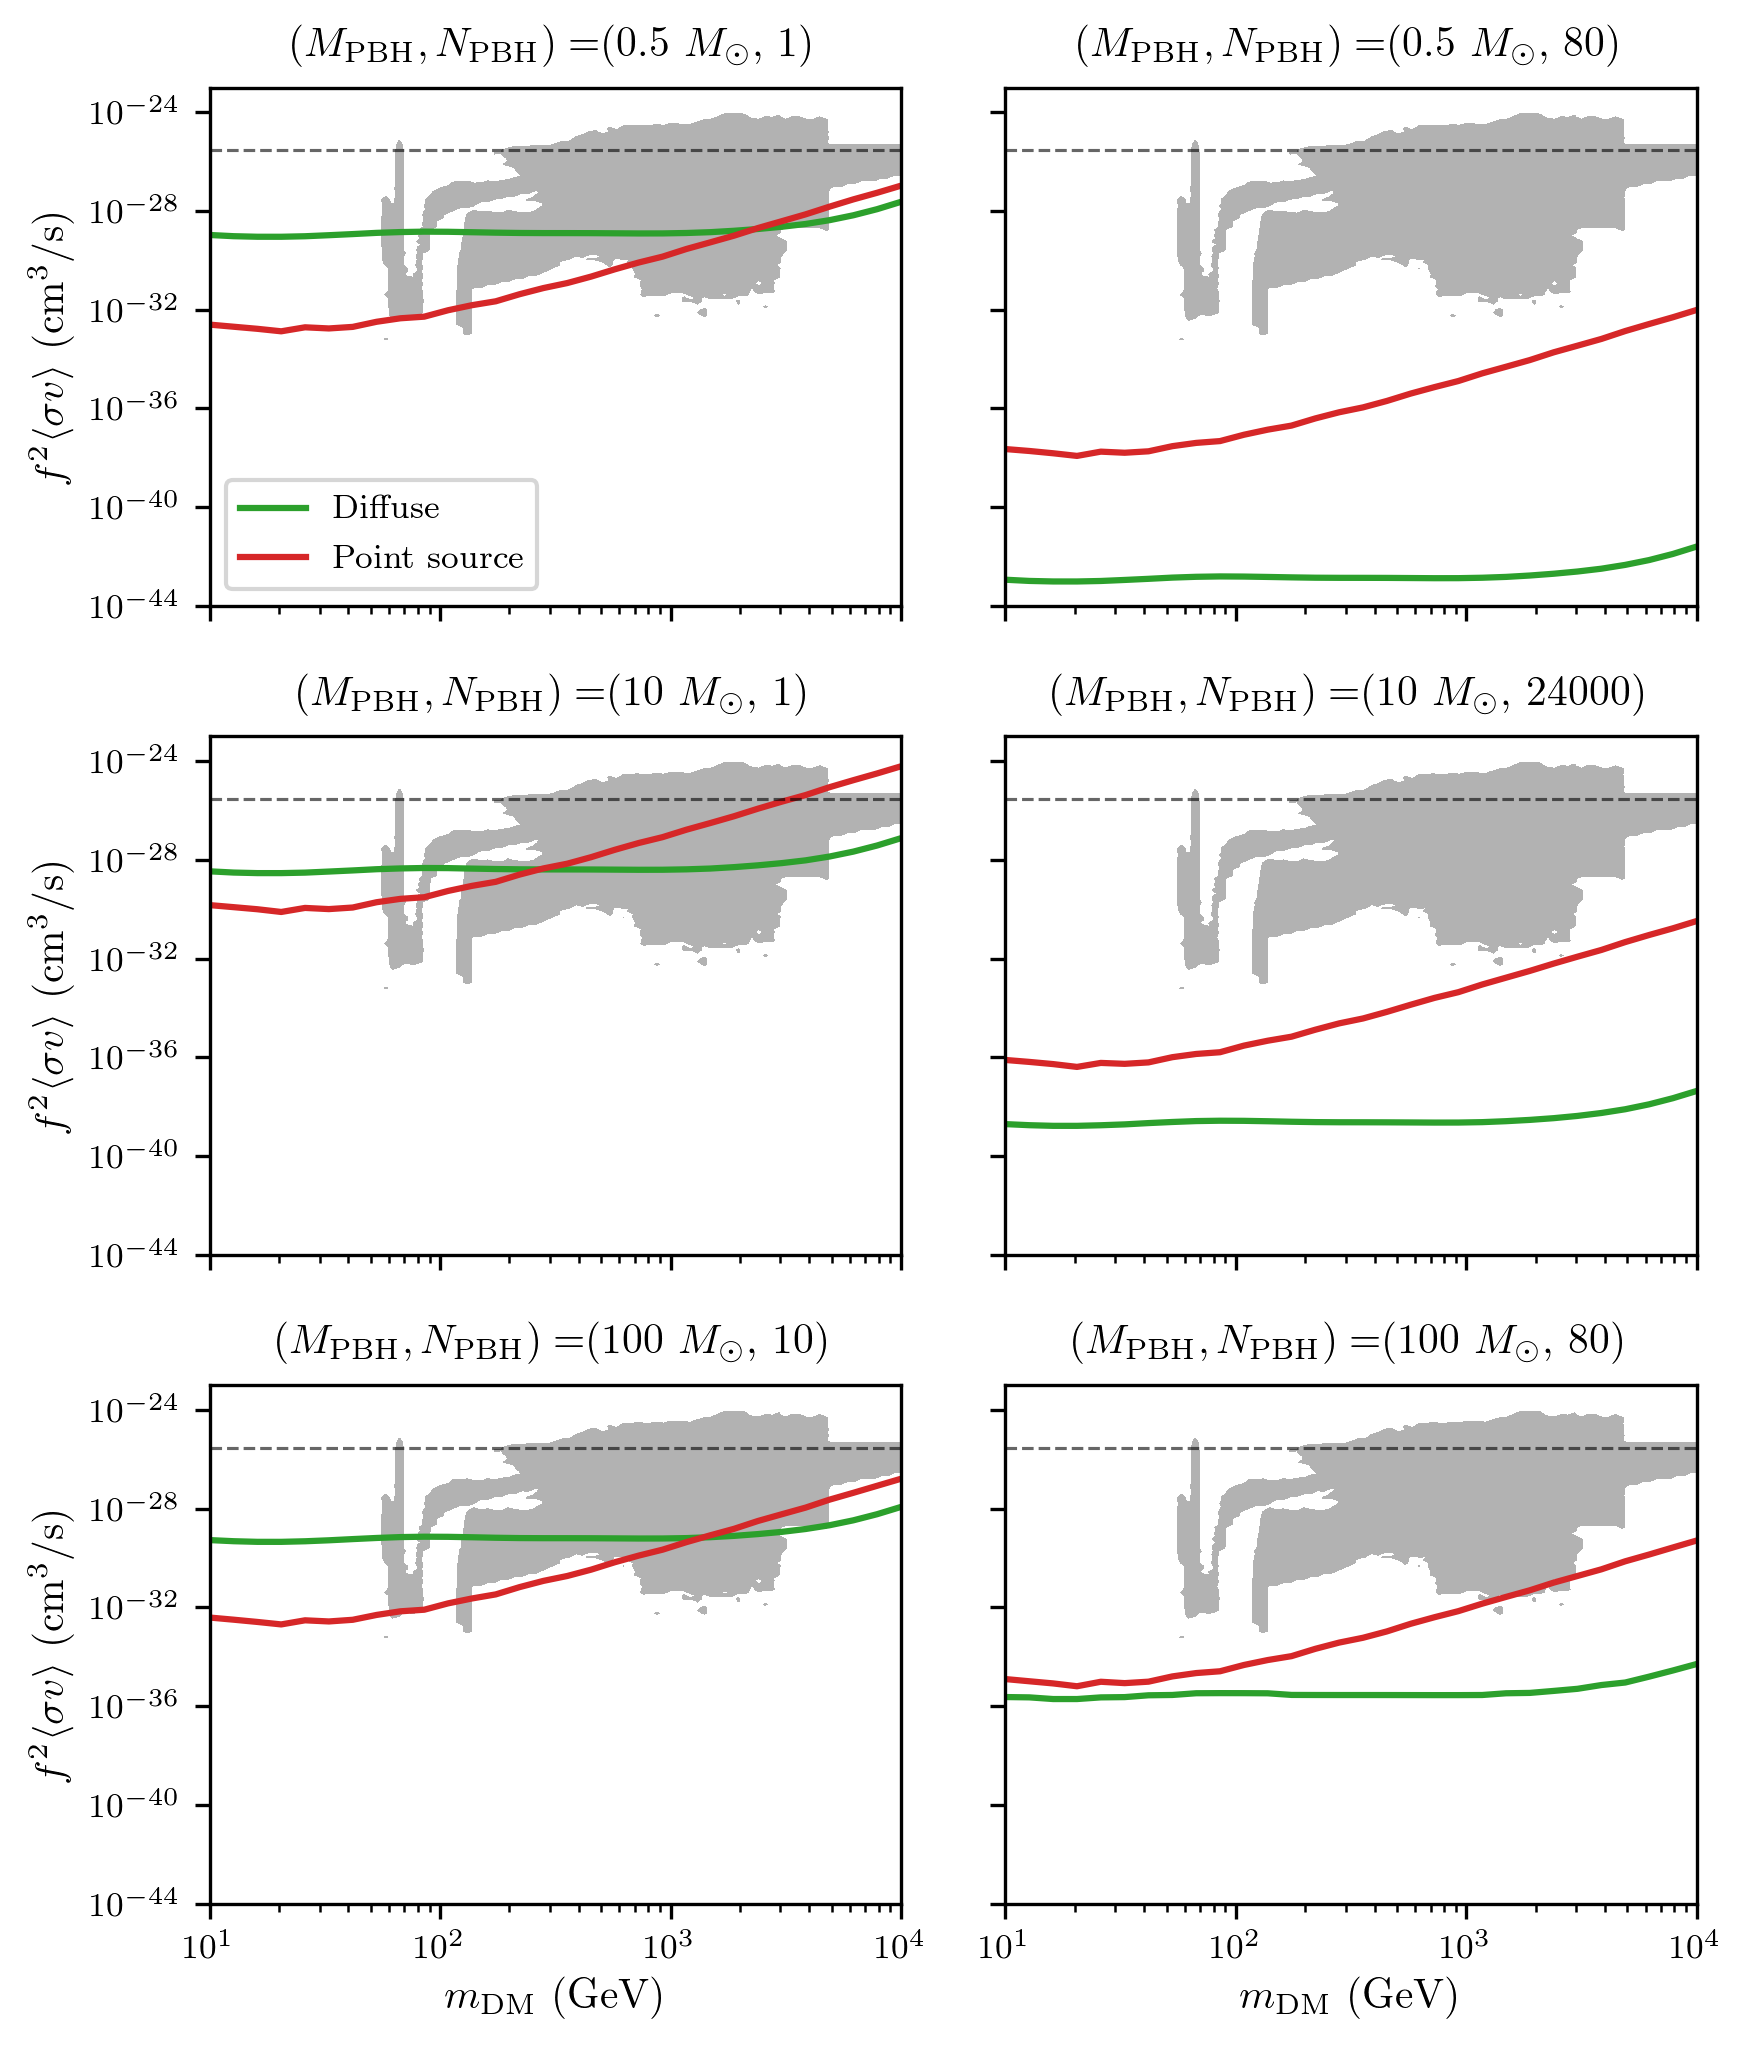

In [50]:
fig, axes = plt.subplots(n_pbhs.shape[0], n_pbhs.shape[1],
                         sharex=True, sharey=True,
                         figsize=(6, 7))

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        m_pbh = m_pbhs[i, j]
        n_pbh = n_pbhs[i, j]
        
        # Diffuse limit
        post_diff = DiffusePosterior(m_pbh, n_pbh, test=False,
                                     merger_rate_prior=merger_rate_prior)
        m_dms, sv_diff_bounds = post_diff.sv_bounds(save=False, alpha=0.95)
        ax.loglog(m_dms, sv_diff_bounds, label="Diffuse", color=colors[2])

        # Point source limit
        post_ps = PointSourcePosterior(m_pbh, n_pbh, test=False,
                                       merger_rate_prior=merger_rate_prior)
        m_dms, sv_ps_bounds = post_ps.sv_bounds(save=False, alpha=0.95)
        ax.loglog(m_dms, sv_ps_bounds, label="Point source", color=colors[3])
        
        # BSM physics contours
        plot_gambit_contour_envelope(ax, 'k')
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle='--', color='k', alpha=0.6, linewidth=0.75)

        # Formatting
        ax.set_xlim(m_dms[[0, -1]])
        ax.set_ylim(1e-44, 1e-23)
        ax.set_title(r"$(M_{\mathrm{PBH}}, N_{\mathrm{PBH}}) = $" +
                     "({:g} $M_\odot$, {:d})".format(m_pbh, n_pbh), fontsize=10)
        if i == axes.shape[0] - 1:
            ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
        if j == 0:
            ax.set_ylabel(r"$f^2 \langle \sigma v \rangle$ (cm$^3$/s)")
        if i == 0 and j == 0:
            ax.legend(fontsize=8)

fig.tight_layout()
fig.savefig("figures/sv_limits_ps_diff_comparison.pdf")

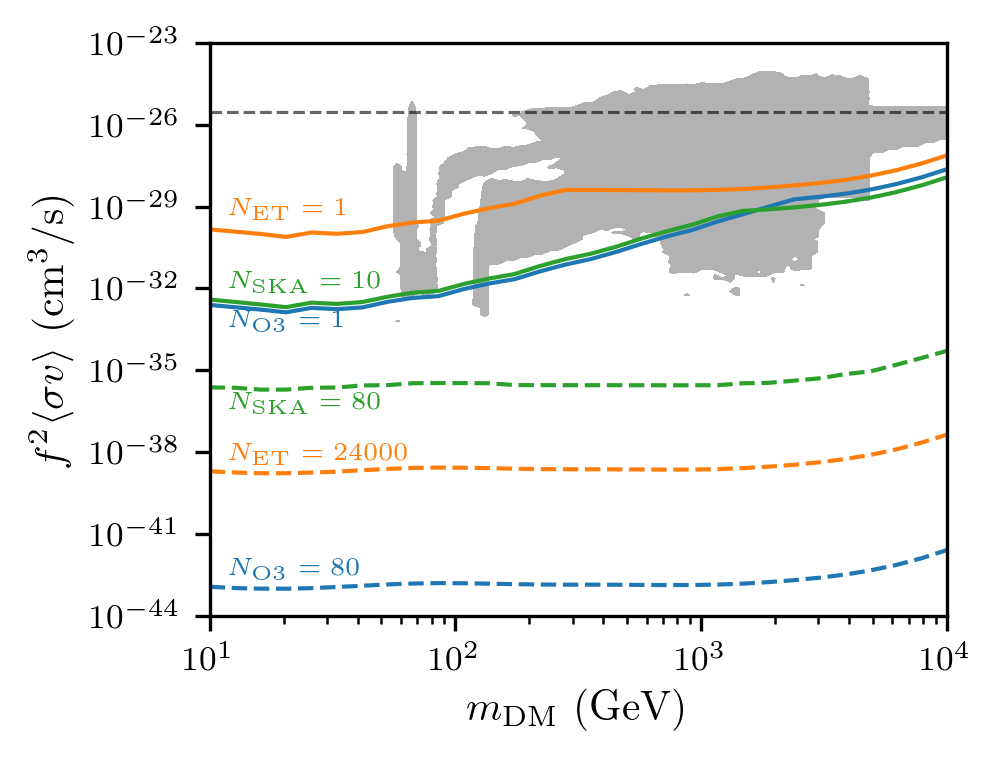

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.7))

for i in range(m_pbhs.shape[0]):
    for j, ls in zip(range(n_pbhs.shape[1]), ["-", "--"]):
        m_pbh = m_pbhs[i, j]
        n_pbh = n_pbhs[i, j]

        # Plot strongest gamma-ray constraint
        post_diff = DiffusePosterior(m_pbh, n_pbh, test=False,
                                     merger_rate_prior=merger_rate_prior)
        post_ps = PointSourcePosterior(m_pbh, n_pbh, test=False,
                                       merger_rate_prior=merger_rate_prior)
        m_dms, sv_diff_bounds = post_diff.sv_bounds(save=False, alpha=0.95)
        m_dms, sv_ps_bounds = post_ps.sv_bounds(save=False, alpha=0.95)
        ax.loglog(m_dms, np.min([sv_diff_bounds, sv_ps_bounds], axis=0),
                  color=pbh_colors[m_pbh], linestyle=ls, linewidth=1)
        
# BSM physics contours
plot_gambit_contour_envelope(ax, 'k')
# Thermal relic cross section
ax.axhline(3e-26, linestyle='--', color='k', alpha=0.6, linewidth=0.75)

# Formatting
ax.set_xlim(m_dms[[0, -1]])
ax.set_ylim(1e-44, 1e-23)
ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
ax.set_ylabel(r"$f^2 \langle \sigma v \rangle$ (cm$^3$/s)")
# N_min labels
ax.text(1.2e1, 3e-30, r"$N_{\mathrm{ET}} = 1$", fontsize=6, color=pbh_colors[10])
ax.text(1.2e1, 6e-33, r"$N_{\mathrm{SKA}} = 10$", fontsize=6, color=pbh_colors[100])
ax.text(1.2e1, 2.5e-34, r"$N_{\mathrm{O3}} = 1$", fontsize=6, color=pbh_colors[0.5])
# N_max lables
ax.text(1.2e1, 2.2e-37, r"$N_{\mathrm{SKA}} = 80$", fontsize=6, color=pbh_colors[100])
ax.text(1.2e1, 3e-39, r"$N_{\mathrm{ET}} = 24000$", fontsize=6, color=pbh_colors[10])
ax.text(1.2e1, 2e-43, r"$N_{\mathrm{O3}} = 80$", fontsize=6, color=pbh_colors[0.5])

fig.tight_layout()
fig.savefig("figures/sv_limits.pdf")